# Fake News Detection: Can we build a classifier that can accurately detect fake news?

In [1]:
from imports import *


### Initial exploration 

In [2]:
true_df = pd.read_csv('True.csv')

true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [3]:
fake_df = pd.read_csv('Fake.csv')

fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [4]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


<AxesSubplot:>

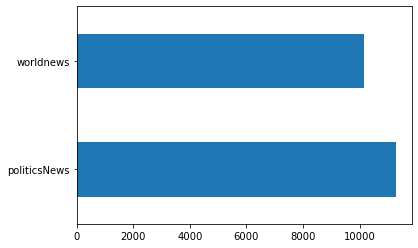

In [7]:
true_df.subject.value_counts().plot.barh()

<AxesSubplot:>

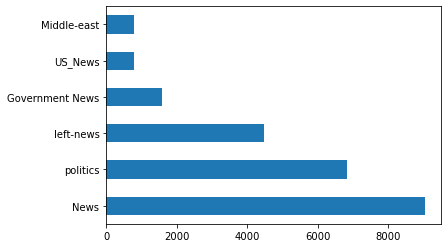

In [9]:
fake_df.subject.value_counts().plot.barh()

In [10]:
print(true_df.text[0])

WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educati

In [15]:
len(true_df.text[0].split())

749

In [11]:
print(fake_df.text[0])

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t eve

In [18]:
len(fake_df.text[0].split())

495

In [19]:
print(true_df.title[0])
print(fake_df.title[0])

As U.S. budget fight looms, Republicans flip their fiscal script
 Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing


### Initial takeaways:

- True news articles have a preamble/external in the format: "CITY (News Association)- "
- There are only two subject types in true articles, but six in fake articles

### Initial data prep/wrangle plan:

- Add a boolean truth value column corresponding to each df
- Standardize columns for ease of access/manipulation (to names that are not reserved words)
- Reorganize subject types
- Prepare text:
    * Make a version of true article that is stripped of externals like "CITY (News Association)- " for ML comparisons
    * Clean fake articles
- Join dfs on axis 0
- Set index to date
- Get word counts for articles (as engineered feature)
    

### Add a boolean truth value column corresponding to each df

In [20]:
# Set truth values for each df
true_df['truth_value'] = True
fake_df['truth_value'] = False

true_df.head(3)
fake_df.head(3)

,title,text,subject,date,truth_value
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True


### Standardize columns for ease of access/manipulation (to names that are not reserved words)

In [22]:
# Standardize columns
true_df.rename(columns= {'title':'article_headline', 'text': 'article_body'}, inplace=True)
fake_df.rename(columns= {'title':'article_headline', 'text': 'article_body'}, inplace=True)
# Print out column lists to check
print(f'True DF columns:\n{true_df.columns}')
print(f'Fake DF columns:\n{fake_df.columns}')

### Reorganize subject types

In [32]:
# Organize subject types in true_df
true_df.subject.replace(to_replace='politicsNews', value='politics', inplace=True)
true_df.subject.replace(to_replace= 'worldnews', value='world', inplace=True)
# Check values
true_df.subject.value_counts()
#fake_df.subject.value_counts()
# Organize subject types in fake_df
fake_df.subject.replace(to_replace= ['left-news', 'Government News', 'Middle-east'], value= ['politics', 'politics', 'world'], inplace=True)
#fake_df.subject.value_counts()
#fake_df[fake_df.subject == 'US_News'].article_body.sample(25)
#fake_df[fake_df.subject == 'US_News'].article_body[22529]
fake_df.subject.replace(to_replace = ['News', 'US_News'], value= ['politics', 'world'], inplace=True)
fake_df.subject.value_counts()

### Prepare text:

- Make a version of true article that is stripped of externals like "CITY (News Association)- " for ML comparisons
- Clean fake articles

In [48]:
true_df['article_stripped'] = true_df.article_body.str.lstrip(r'[A-Z]+\s\([\w+]\)\s-$')

In [49]:
true_df.article_stripped[0]

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat